In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


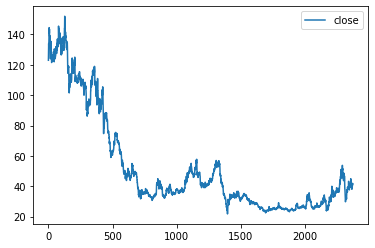

In [2]:
f=open('8046_2010_2019.csv')  
df=pd.read_csv(f)     #讀入股票數據
df=df.dropna(axis=0,how='all')  #删除表中全部為NaN的行
data=np.array(df[['close']])

# Plot
df[['close']].plot(figsize=(6,4))

In [3]:
len(data)

2372

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

### 切分 Train data

In [5]:
print(df.shape[0])
time_step=10      #看10天預測第11天
rnn_unit=15       #hidden layer units
batch_size=60     #每一批次訓練多少個data
input_size=1      #輸入層维度
output_size=1     #輸出層维度
lr=0.0006         #學習率
train_X,train_Y=[],[]   #訓練集
print(len(data)-time_step-1-30)
for i in range(len(data)-time_step-1-30):    
    # 拿 1~10 天，預測第 11 天
    # print(i, i+time_step)
    x=data[i:i+time_step] 
    y=data[i+time_step+1]
    train_X.append(x.tolist())
    train_Y.append(y.tolist())
print((len(train_X), train_X[0]))
print((len(train_Y), train_Y[0]))

2372
2331
(2331, [[0.7772657450076805], [0.8348694316436254], [0.8617511520737329], [0.8425499231950846], [0.8771121351766515], [0.9155145929339479], [0.9423963133640554], [0.9155145929339479], [0.9347158218125962], [0.9001536098310294]])
(2331, [0.8771121351766515])


### 切分 Test data

In [6]:
test_x,test_y=[],[]  
for i in range(30):
    x = data[i-30-time_step : i-30]
    test_x.append(x.tolist())
    
for i in range(30):
    y = data[i-30]
    test_y.append(y.tolist())
  
print(test_x[29])
print(test_y[29])

[[0.14631336405529954], [0.13978494623655913], [0.12634408602150538], [0.13786482334869432], [0.12596006144393246], [0.13824884792626724], [0.1440092165898617], [0.14132104454685102], [0.14823348694316435], [0.15399385560675882]]
[0.15207373271889402]


TensorFlow 101：常數、變數與 Placeholder https://medium.com/datainpoint/tf101-constants-variables-and-placeholders-d36cf13d9e21

https://www.tensorflow.org/api_docs/python/tf/compat/v1/placeholder

```
tf.compat.v1.placeholder(
    dtype, shape=None, name=None
)
```



In [0]:
X=tf.placeholder(tf.float32, [None,time_step,input_size], name='X')    #每批次輸入網路的tensor
Y=tf.placeholder(tf.float32, [None,output_size], name='Y')   #每批次tensor對應的標籤
# keep_prob=tf.placeholder(tf.float32, name='keep_prob')

In [0]:
#輸入層、輸出層權重、偏置
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit]) ,name='w_in'),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]) ,name='w_out')
         }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit]) ,name='b_in'),
        'out':tf.Variable(tf.constant(0.1,shape=[1]) ,name='b_out')
        }

In [9]:
weights

{'in': <tf.Variable 'w_in:0' shape=(1, 15) dtype=float32_ref>,
 'out': <tf.Variable 'w_out:0' shape=(15, 1) dtype=float32_ref>}

### 定義神經網路變量

* https://www.tensorflow.org/api_docs/python/tf/compat/v1/nn/dynamic_rnn
```
tf.compat.v1.nn.dynamic_rnn(
    cell, inputs, sequence_length=None, initial_state=None, dtype=None,
    parallel_iterations=None, swap_memory=False, time_major=False, scope=None
)
```
回傳的 final_states: c 是長期，h 是長期
```
LSTMStateTuple(c=<tf.Tensor 'train_17/rnn/while/Exit_3:0' shape=(60, 10) dtype=float32>, 
  h=<tf.Tensor 'train_17/rnn/while/Exit_4:0' shape=(60, 10) dtype=float32>)
```



In [0]:
def lstm(batch_size, time_step, input_size):      #參數：輸入網路批次數目
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  #需要將tensor轉成2维進行計算，計算後的结果作為隱藏層的輸入
    # -1代表的含義是不用我們自己指定這一維的大小，函式會自動計算，但列表中只能存在一個-1.
    
    input_rnn=tf.nn.relu(tf.matmul(input,w_in)+b_in)  #hidden layer
    print(input)
    print(input_rnn)
    input_rnn=tf.nn.dropout(input_rnn, keep_prob=0.5)
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #將tensor轉成3维，作為lstm cell的輸入
    cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit) # create a BasicRNNCell
    mlstm_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([cell]*3, state_is_tuple = True)  #建立多層的LSTM
    init_state=cell.zero_state(batch_size,dtype=tf.float32) # defining initial state
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn, initial_state=init_state, dtype=tf.float32)  

    print('output_rnn:', output_rnn)
    print('final_states:', final_states)

    #output_rnn是紀錄lstm每個輸出節點的结果，final_states是最後一個cell的结果
    # output=tf.reshape(final_states,[-1,rnn_unit]) #作為輸出層的輸入, 用final_states
    # print('output:', output)

    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(final_states[1],w_out)+b_out # 直接用final_states[1] > 短期?? 原本是output
    print(input_rnn)
    print(w_in)
    return pred,final_states

### 訓練模型

In [11]:
def train_lstm():
    global batch_size
    pred,_=lstm(batch_size, time_step, input_size)
    print(pred)
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))  
    #loss function:MSE(mean square error)
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(2000):
            step=0
            start=0
            end = start+batch_size
            while(end<len(train_X)):
                _,loss_ = sess.run([train_op,loss],feed_dict={X:train_X[start:end],Y:train_Y[start:end]}) # here 噴錯
                start += batch_size
                end = start + batch_size
                #每50步保存一次参数
                if step%50 == 0 :
                    print(i,step,loss_)
                    print("保存模型：",saver.save(sess,'stock.model2'))
                step += 1            
with tf.variable_scope('train',reuse=tf.AUTO_REUSE):
    train_lstm()

Tensor("train/Reshape:0", shape=(?, 1), dtype=float32)
Tensor("train/Relu:0", shape=(?, 15), dtype=float32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
output_rnn: Tensor("train/rnn/transpose_1:0", shape=(60, 10, 15), dtype=float32)
final_states: LSTMStateTuple(c=<tf.Tensor 'train/rnn/while/Exit_3:0' shape=(60, 15) dtype=float32>, h=<tf.Tensor 'train/rnn/while/Exit_4:0' shap

### 預測模型

In [12]:
# 重抓測試集的真實股價，因為data在訓練時被scale過
real_test = []

f=open('8046_2010_2019.csv')  
df=pd.read_csv(f)     #讀入股票數據
df=df.dropna(axis=0,how='all')  #删除表中全部為NaN的行
data=np.array(df[['close']])

for i in range(30):
    y = data[i-30]
    real_test.append(y.tolist())

test_y = real_test
print(test_y[29])

[41.6]


In [0]:
def prediction():
    pred1,_=lstm(1,time_step,1)      #預測時只輸入[1,time_step,input_size]的測試資料
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        #參數恢復
        module_file = tf.train.latest_checkpoint('')
        saver.restore(sess, module_file) 
        print('test_x:',test_x)
        print('test_x len:',len(test_x))
        test_predict=[]
        
        #得到預測結果
        for i in range(len(test_x)):
            prob=sess.run(pred1,feed_dict={X:[test_x[i]]})   
            predict=prob.reshape((-1))
            test_predict.extend(predict)
            
        #從正規化還原預測股價
        forecast = scaler.inverse_transform([test_predict])[0]
        print('test_predict:', forecast)
        print('test_predict len:', len(forecast))

        # 以下OK

        plt.figure()
        plt.plot(list(range(len(forecast))), forecast, color='r')
        plt.plot(list(range(len(test_y))), test_y,  color='b')
        plt.show()
        
        acc = np.sum(np.abs(list(test_y[i] - forecast[i] for i in range(len(test_y)))))/len(test_y)
        print(acc)
   

        c = {"real" : test_y,"predict" : forecast}
        test = pd.DataFrame(c)
        #test=test.T
        print(test)

Tensor("train_1/Reshape:0", shape=(?, 1), dtype=float32)
Tensor("train_1/Relu:0", shape=(?, 15), dtype=float32)
output_rnn: Tensor("train_1/rnn/transpose_1:0", shape=(1, 10, 15), dtype=float32)
final_states: LSTMStateTuple(c=<tf.Tensor 'train_1/rnn/while/Exit_3:0' shape=(1, 15) dtype=float32>, h=<tf.Tensor 'train_1/rnn/while/Exit_4:0' shape=(1, 15) dtype=float32>)
Tensor("train_1/Reshape_1:0", shape=(?, 10, 15), dtype=float32)
<tf.Variable 'w_in:0' shape=(1, 15) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from stock.model2
test_x: [[[0.12596006144393246], [0.1328725038402458], [0.12826420890937018], [0.13018433179723504], [0.13632872503840243], [0.1347926267281106], [0.16474654377880182], [0.16397849462365588], [0.152457757296467], [0.15168970814132104]], [[0.1328725038402458], [0.12826420890937018], [0.13018433179723504], [0.13632872503840243], [0.1347926267281106], [0.16474654377880182], [0.16397849462365588], [0.152457757296467], [0.15168970814132104], [0.152841781874039

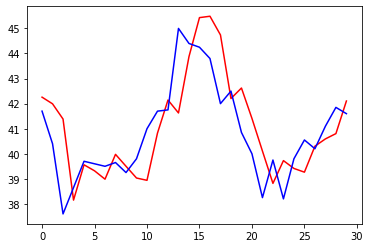

1.1057566836476318
       real    predict
0    [41.7]  42.257818
1    [40.4]  41.992220
2    [37.6]  41.384606
3   [38.65]  38.150906
4    [39.7]  39.559876
5    [39.6]  39.319714
6    [39.5]  38.985985
7   [39.65]  39.976422
8   [39.25]  39.501497
9    [39.8]  39.032199
10   [41.0]  38.940446
11   [41.7]  40.825493
12  [41.75]  42.144357
13   [45.0]  41.628030
14   [44.4]  43.875610
15  [44.25]  45.431345
16   [43.8]  45.486355
17   [42.0]  44.740538
18   [42.5]  42.203588
19  [40.85]  42.622611
20   [40.0]  41.410380
21  [38.25]  40.108562
22  [39.75]  38.818158
23   [38.2]  39.726232
24   [39.8]  39.414117
25  [40.55]  39.265790
26   [40.2]  40.301900
27   [41.1]  40.592735
28  [41.85]  40.803773
29   [41.6]  42.104276


In [14]:
with tf.variable_scope('train',reuse=True):
    prediction() 